In [1]:
%load_ext autoreload
%autoreload 2
%run imports_notebook.py

import torch
from torchvision import transforms
import clip
from PIL import Image
model, preprocess = clip.load("ViT-B/32", device=device)
from image_cppn import ImageCPPN

In [2]:
def imshow(img, mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]):
    """
    img.shape should be (3, h, w) on any device, torch tensor
    """
    img = img.detach().cpu()
#     mean = torch.tensor(mean)
#     std = torch.tensor(std)
    img = img.permute(1, 2, 0)
#     img = img*std+mean
    img = img.clamp(0, 1).numpy()
    plt.imshow(img)

In [8]:
# Load CLIP nouns
# Ask GPT3: Here is a list of fifty objects from nature:
nouns = ['a rock', 'a tree', 'a flower', 'a blade of grass', 'a leaf', 'a cloud', 'the sun', 'the moon', 'the stars', 'the sky', 'a river', 'a waterfall', 'the ocean', 'a wave',
        'a stone', 'a pebble', 'a grain of sand', 'a drop of water', 'a raindrop', 'a snowflake', 'a flake of snow', 'an ice cube', 'a piece of ice', 'a glacier', 'a piece of wood',
         'a log', 'a stick', 'a twig', 'a branch', 'a tree trunk', 'a piece of bark', 'a nut', 'a seed', 'a fruit', 'a vegetable', 'a leaf', 'a root', 'a bulb', 'a flower',
         'a stem', 'a vine', 'a root system', 'a mountain', 'a lake', 'a cliff', 'a cave', 'an apple', 'a banana', 'a pineapple']
print(len(nouns))
NUM_IMAGES_SQRD = 7
NUM_IMAGES = 49

text = clip.tokenize(['a photo of ' + x for x in nouns]).to(device)
print(text.shape, text.dtype, text.device)

with torch.no_grad():
    text_features = model.encode_text(text).detach()
print(text_features.shape)

49
torch.Size([49, 77]) torch.int32 cuda:0
torch.Size([49, 512])


In [9]:
resize_trans = transforms.RandomResizedCrop(224, scale=(1.0, 1.0))

def display_archive(archive, nouns, updated):
    with torch.no_grad():
        imgs = torch.stack([cppn.generate_image((64, 64))[0] for cppn in archive])
        imgs = resize_trans(imgs)
        imgs_features = model.encode_image(imgs)

        clip_scores = torch.cosine_similarity(imgs_features, text_features, dim=-1)

        plt.figure(figsize=(NUM_IMAGES_SQRD*2, NUM_IMAGES_SQRD*2.3))
        for i_img, img in enumerate(imgs):
            plt.subplot(NUM_IMAGES_SQRD, NUM_IMAGES_SQRD, i_img+1)
            plt.axis('off')
            if updated[i_img]:
                plt.title('{}\n[{:.4f}]'.format(nouns[i_img], clip_scores[i_img].item()), fontweight='bold')
            else:
                plt.title('{}\n*[{:.4f}]*'.format(nouns[i_img], clip_scores[i_img].item()))
            imshow(img)
        plt.show()

In [10]:
# # Archive of CPPNs, one for each niche
# archive = []
# for i in range(NUM_IMAGES):
#     cppn = ImageCPPN(n_hidden=20, n_layers=8, n_channels=3, activation=torch.relu, give_radius=True).to(device)
#     archive.append(cppn)
    
# # display_archive(archive, nouns)

In [11]:
# augment_trans = transforms.Compose([
#     transforms.RandomPerspective(distortion_scale=0.5, p=1, fill=1),
#     transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
#     transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
# ])

# params = []
# for cppn in archive:
#     params += list(cppn.parameters())
# optim = torch.optim.Adam(params, lr=1e-3)
    
# for i in range(10000):
#     print(i)
#     imgs = []
#     for n, cppn in enumerate(archive):
#         img = cppn.generate_image((64, 64))
#         for _ in range(4):
#             imgs.append(augment_trans(img))
            
#     img_augments = torch.cat(imgs, dim=0)
#     image_features = model.encode_image(img_augments)

#     loss = 0
#     for n in range(NUM_IMAGES):
#         loss -= torch.cosine_similarity(image_features[4*n:4*(n+1)], text_features[n]).mean()

#     optim.zero_grad()
#     loss.backward()
#     optim.step()
    
#     if i % 100 == 0:
#         display_archive(archive, nouns)

  0%|          | 0/10000 [00:00<?, ?it/s]

0


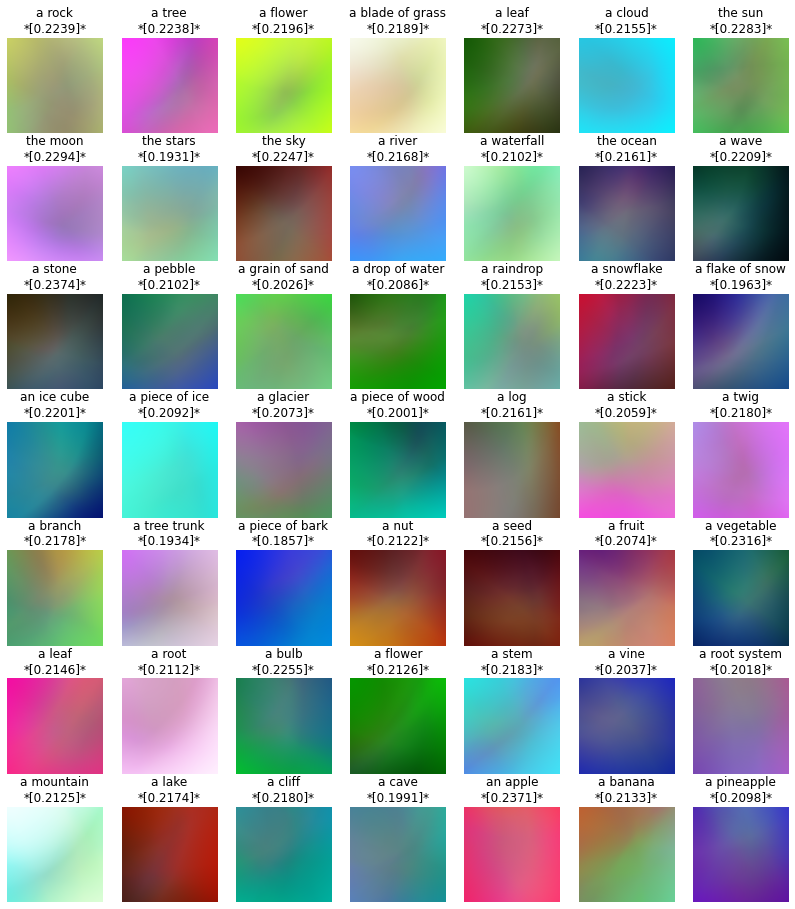

1
2
3
4
5
6
7
8
9
10


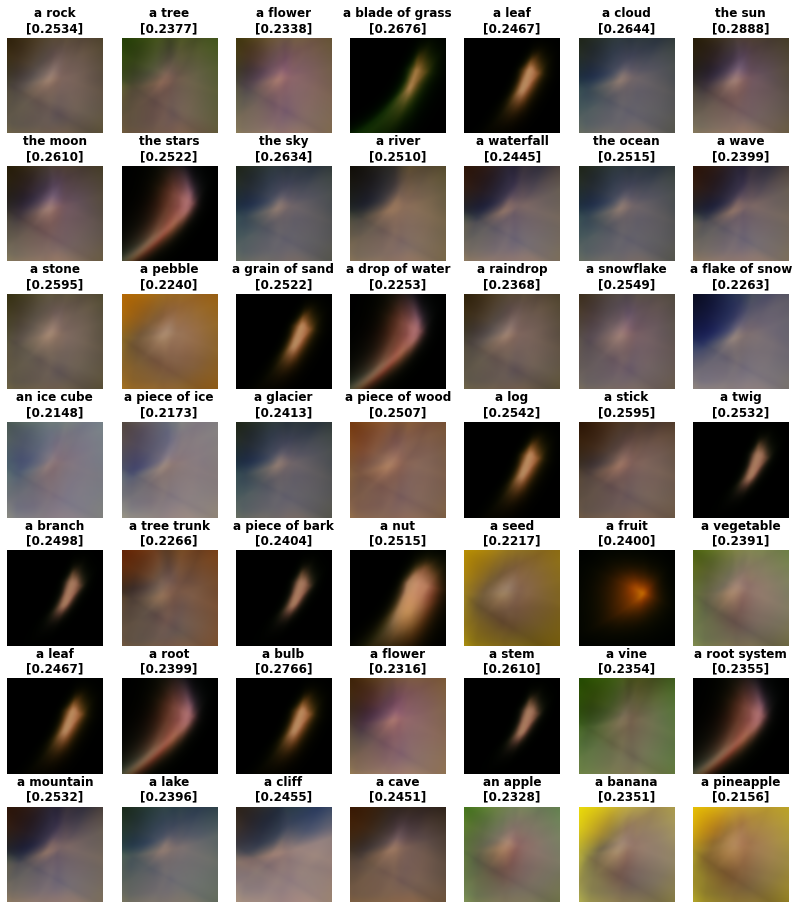

11
12
13
14
15
16
17
18
19
20


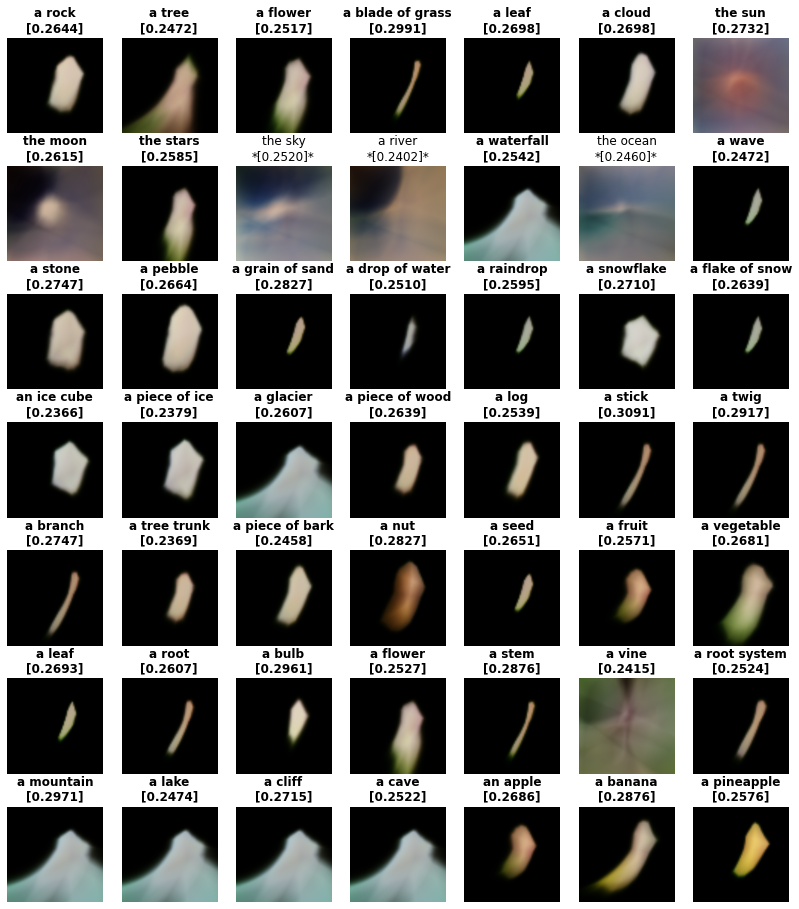

21
22
23
24
25
26
27
28
29
30


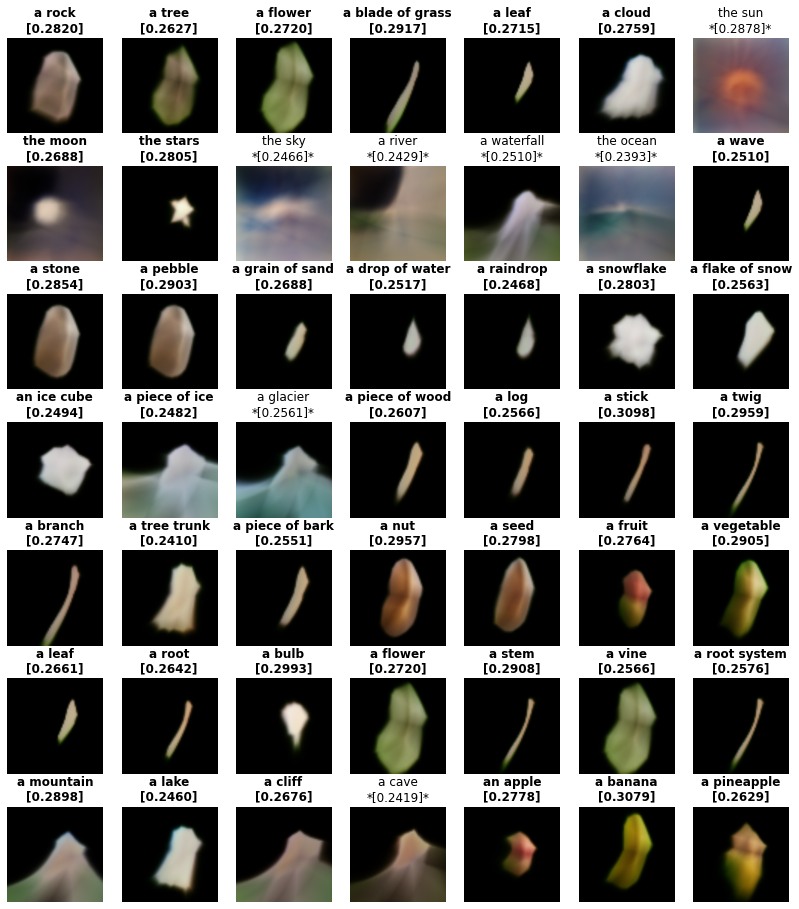

31
32
33
34
35
36
37
38
39
40


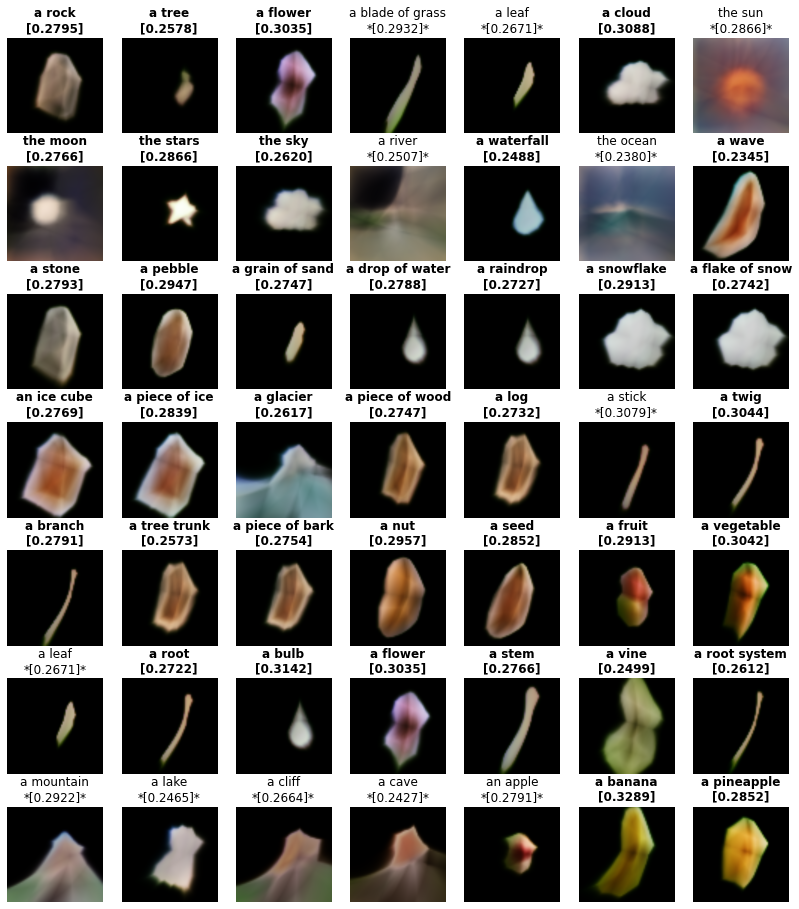

41
42
43
44
45
46
47
48
49
50


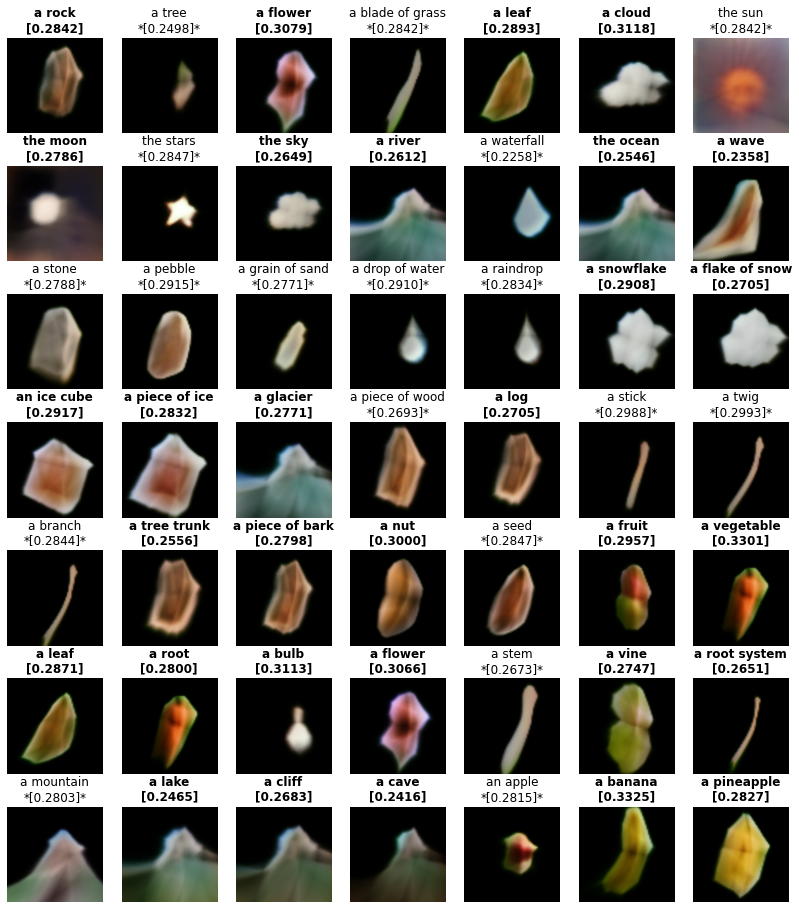

51
52
53
54
55
56



KeyboardInterrupt



In [13]:
augment_trans = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.5, p=1, fill=1),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

cppn_args = dict(n_hidden=20, n_layers=8, n_channels=3, activation=torch.relu)

# Initialize Archive
archive = []
scores = []
updated = np.zeros(NUM_IMAGES)
for i in range(NUM_IMAGES):
    cppn = ImageCPPN(**cppn_args).to(device)
    archive.append(cppn)
    scores.append(0)

    
for i in tqdm(range(10000)):
    print(i)
    if i % 10 == 0:
        display_archive(archive, nouns, updated)
        updated = np.zeros(NUM_IMAGES)
    # Optimization iteration
    copies = []
    for cppn in archive:
        state_dict = cppn.state_dict()
        new_cppn = ImageCPPN(**cppn_args).to(device)
        new_cppn.load_state_dict(state_dict)
        copies.append(new_cppn)
    params = []
    for cppn in copies:
        params += list(cppn.parameters())
    optim = torch.optim.Adam(params, lr=1e-3)
    
    # Assign targets randomly
    targets = np.random.randint(NUM_IMAGES, size=(NUM_IMAGES))
    for n in range(NUM_IMAGES):
        if np.random.uniform() < 1:
            targets[n] = n
#     print(targets)
    
    # Run optimization for 20 iterations
    for c in range(20):
        imgs = []
        for n, cppn in enumerate(copies):
            img = cppn.generate_image((64, 64))
            for _ in range(4):
                imgs.append(augment_trans(img))

        img_augments = torch.cat(imgs, dim=0)
        image_features = model.encode_image(img_augments)

        loss = 0
        for n in range(NUM_IMAGES):
            loss -= torch.cosine_similarity(image_features[4*n:4*(n+1)], text_features[n]).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()
        
    for n in range(NUM_IMAGES):
        archive[n].load_state_dict(copies[n].state_dict())
    
#     Check if image displaces any others
    with torch.no_grad():
        imgs = torch.stack([cppn.generate_image((64, 64))[0] for cppn in copies])
        imgs = resize_trans(imgs)
        imgs_features = model.encode_image(imgs) # 49 x 128
        
        for n in range(NUM_IMAGES):
            clip_scores = torch.cosine_similarity(imgs_features[n], text_features, dim=-1)
            for m in range(NUM_IMAGES):
                if clip_scores[m] > scores[m]:
                    updated[m] = True
                    scores[m] = clip_scores[m].item()
                    archive[m].load_state_dict(copies[n].state_dict())
    del copies

In [ ]:
display_archive(archive, nouns)